In [42]:
import time
import numpy as np
import pandas as pd
from textblob import TextBlob
import sklearn
from pycorenlp import StanfordCoreNLP
from micromort.utils.classification_plotter import plot_classification_report
import sys
reload(sys)
sys.setdefaultencoding('utf8')
from newspaper import Article

In [2]:
data_dump = pd.read_csv("./annotator_data_dump_with_polarity", delimiter="\t")
data_dump = data_dump[data_dump.polarity != 9].reset_index(drop=True)

In [3]:
data_dump['e'] = pd.Series(np.zeros(data_dump.shape[0]), index=data_dump.index)
data_dump.head()

,url,summary,category,title,polarity,e
0,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,92,Russian hackers said to have stolen US cyber s...,-1,0.0
1,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,94,Russian hackers said to have stolen US cyber s...,-1,0.0
2,http://www.channelnewsasia.com/news/health/to-...,(Reuters Health) - The best way to get teens t...,99,"To grow teen athletes, let kids try lots of sp...",0,0.0
3,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,94,Protests in Asia against Trump's decision on J...,-1,0.0
4,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,98,Protests in Asia against Trump's decision on J...,-1,0.0


In [4]:
for index, row in data_dump.iterrows():
    data = row["title"]
    blob = TextBlob(data.decode('utf-8').strip())
    if (blob.sentiment.polarity < .1 and blob.sentiment.polarity > -.1):
        data_dump["e"].values[index] = 0
    elif (blob.sentiment.polarity > .1):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1

In [5]:
sklearn.metrics.accuracy_score(data_dump["e"].values, data_dump["polarity"].values)

0.30082358040745555

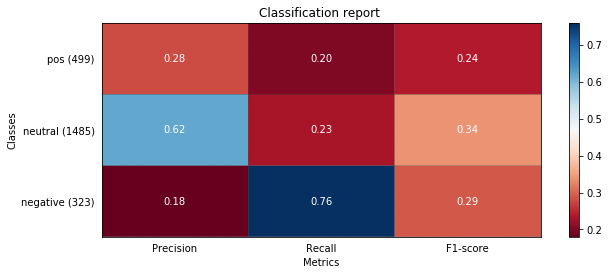

In [6]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values, data_dump["polarity"].values, target_names=["negative", "neutral", "pos"]))

## Standford Deeply Moving: Deep Learning for Sentiment Analysis

In [7]:
nlp = StanfordCoreNLP('http://localhost:9000')
def get_sentiment(x):
    res = nlp.annotate(x,
                       properties={
                           'annotators': 'sentiment',
                           'outputFormat': 'json'
                       })
    try:
        return res["sentences"][0]["sentiment"]
    except Exception:
        print Exception
        return ""

In [14]:
for index, row in data_dump.iterrows():
    data = row["summary"].decode('utf-8').strip()
    
    sentiment = get_sentiment(data)
    if (sentiment == "Neutral"):
        data_dump["e"].values[index] = 0
    elif (sentiment == "Positive"):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1

KeyboardInterrupt: 

### On title:

In [129]:
sklearn.metrics.accuracy_score(data_dump["e"].values, data_dump["polarity"].values)

0.49111400086692675

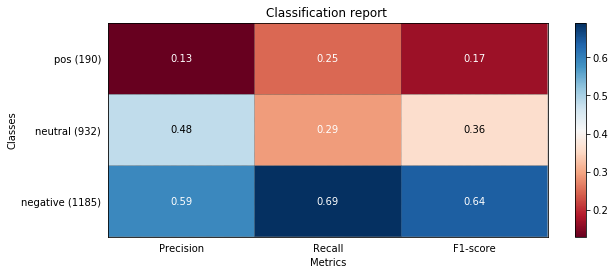

In [130]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values, data_dump["polarity"].values, target_names=["negative", "neutral", "pos"]))

### On summary:

In [137]:
sklearn.metrics.accuracy_score(data_dump["e"].values, data_dump["polarity"].values)

0.5908105765062852

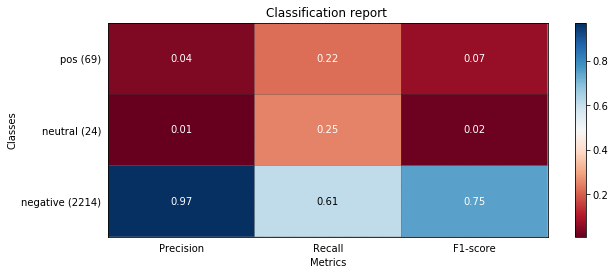

In [138]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values, data_dump["polarity"].values, target_names=["negative", "neutral", "pos"]))

### On text:

In [186]:
for index, row in data_dump.iterrows():
    print row["url"]
    a = Article(row["url"])
    print "Downloading", a.url
    a.download()
    print "parsing", a.url
    a.parse()
    data_dump.ix[index, "text"] = a.text

In [28]:
for index, row in data_dump.iterrows():
    data = row["text"].encode('utf-8').strip()
    
    sentiment = get_sentiment(data)
    if (sentiment == "Neutral"):
        data_dump["e"].values[index] = 0
    elif (sentiment == "Positive"):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1

In [29]:
sklearn.metrics.accuracy_score(data_dump["e"].values, data_dump["polarity"].values)

0.5808409189423493

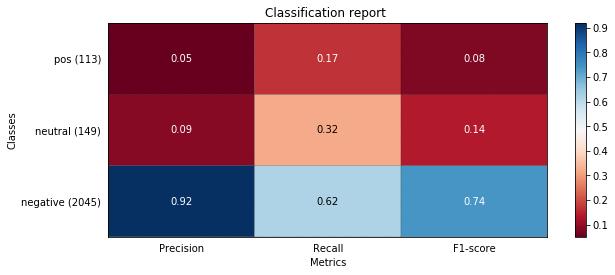

In [30]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values, data_dump["polarity"].values, target_names=["negative", "neutral", "pos"]))

### aylien APIs

In [36]:
from aylienapiclient import textapi
client = textapi.Client("06ef7dde", "37bd8e6e7eaaec39510f8de755821293")

In [44]:
count=0
for index, row in data_dump.iterrows():
    data = row["text"].encode('utf-8').strip()
    try:
        sentiment = client.Sentiment({'text':data})["polarity"]
    except Exception as e:
        print e
    print sentiment
    if (sentiment == "Neutral" or sentiment == 'neutral'):
        data_dump["e"].values[index] = 0
    elif (sentiment == "Positive" or sentiment == "positive"):
        data_dump["e"].values[index] = 1
    else: 
        data_dump["e"].values[index] = -1
    if count%60 == 0:
        time.sleep(60)
    count=count+1
    

KeyboardInterrupt: 

In [49]:
sklearn.metrics.accuracy_score(data_dump["e"].values[:660], data_dump["polarity"].values[:660])

0.2727272727272727

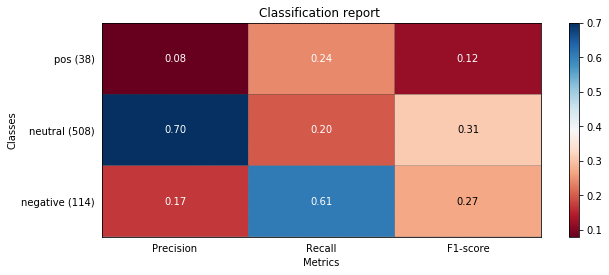

In [50]:
plot_classification_report(sklearn.metrics.classification_report(data_dump["e"].values[:660], data_dump["polarity"].values[:660], target_names=["negative", "neutral", "pos"]))

In [85]:
j = {
  "documents": [
    {
      "id": "1",
      "text": "Hate"
    },
      {
      "id": "2",
      "text": "Hello fucking world."
    },
      {
      "id": "3",
      "text": "Life is dull. I still hate it."
    },
      {
      "id": "4",
      "text": "My girlfriend is a bitch"
    },
  ]
}

In [86]:
import httplib, urllib, base64, json

headers = {
    # Request headers
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': '9116275d25b042138905e5f73af44138',
}

params = urllib.urlencode({})
conn = httplib.HTTPSConnection('southeastasia.api.cognitive.microsoft.com')



####################################

In [165]:
df_unique = data_dump.drop_duplicates(subset='text')

In [167]:
count = 0
gd = []
preds = []
for index, row in df_unique.iterrows():
    data = row["text"].encode('utf-8').strip()[:5000]
    j = {"documents": [{"id":"1", "text":data}]}
    try:    
        conn.request("POST", "/text/analytics/v2.0/sentiment?%s" % params, json.dumps(j), headers)
        response = conn.getresponse()
        resp = response.read()
        score = json.loads(resp)["documents"][0]["score"]
        gd.append(df_unique.at[index,"polarity"])
        p = 0
        if score < .33:
            p = -1
        elif score > .66:
            p = 1
        else:
            p = 0
        preds.append(p)
        print row["title"], p
    except Exception as e:
        print e
    
    conn.close()
    if count%5 == 0:
        time.sleep(1)
    count = count+1

In [171]:
sklearn.metrics.accuracy_score(preds, gd)

0.4026548672566372

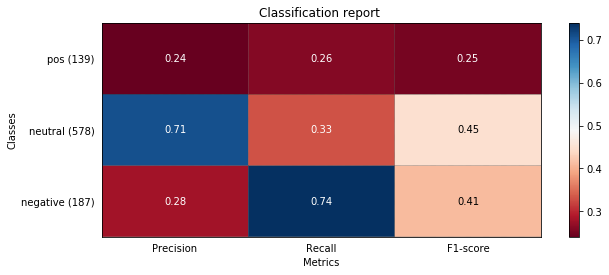

In [172]:
plot_classification_report(sklearn.metrics.classification_report(preds, gd, target_names=["negative", "neutral", "pos"]))

In [200]:
b = data_dump

In [210]:
for index, row in b.iterrows():
    data = row["text"].encode('utf-8').strip()
    b["text"].values[index] = re.sub(r"[\"\n\s+]", " ", row["text"])
#re.sub(r"[\"\n\s+]", " " ,b["text"][0])

In [216]:
b.to_csv("../data/annotator_data_dump_with_polarity",index=False)

In [217]:
d = pd.read_csv("../data/annotator_data_dump_with_polarity")

In [218]:
d

,url,summary,category,title,polarity,e,text
0,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,92,Russian hackers said to have stolen US cyber s...,-1,0.0,WASHINGTON (REUTERS) - Russian government-back...
1,http://www.straitstimes.com/world/united-state...,WASHINGTON (REUTERS) - Russian government-back...,94,Russian hackers said to have stolen US cyber s...,-1,0.0,WASHINGTON (REUTERS) - Russian government-back...
2,http://www.channelnewsasia.com/news/health/to-...,(Reuters Health) - The best way to get teens t...,99,"To grow teen athletes, let kids try lots of sp...",0,-1.0,LONDON: The best way to get teens to play spor...
3,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,94,Protests in Asia against Trump's decision on J...,-1,0.0,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...
4,http://www.straitstimes.com/asia/se-asia/prote...,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...,98,Protests in Asia against Trump's decision on J...,-1,0.0,JAKARTA/KUALA LUMPUR - Muslim protesters ralli...
5,http://www.asiaone.com/health/zika-virus-singa...,SINGAPORE - Analysis of the Zika virus found i...,91,Zika virus in Singapore likely from Asian stra...,-1,0.0,SINGAPORE - Analysis of the Zika virus found i...
6,http://www.asiaone.com/health/good-or-bad-look...,"Canola oil, which is extracted from the seeds ...",91,Good or bad? A look at myths and facts about c...,-1,1.0,SINGAPORE - Canola oil used to be the healthy ...
7,http://www.asiaone.com/china/china-punishes-of...,SHANGHAI - China has punished officials in the...,93,China punishes officials for tampering with sm...,-1,0.0,Beijing plans to establish an environmental po...
8,http://www.asiaone.com/china/china-punishes-of...,SHANGHAI - China has punished officials in the...,95,China punishes officials for tampering with sm...,-1,0.0,Beijing plans to establish an environmental po...
9,http://www.asiaone.com/digital/upcoming-featur...,Return of the Start menu: Windows 10 brings ba...,99,The upcoming features in Windows 10,0,0.0,Return of the Start menu: Windows 10 brings ba...
